In [1]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    Load in stimulus and spike files
"""
# load stimulus
with open('stimulus.txt','r') as f:
    # create list to store stimulus
    stimulus = []
    # read in every line of file, split into list pairs, convert to float (seconds)
    for line in f:
        stimulus.append([float(v)/1000 for v in line.rstrip().split('\t')])

# load spike file
with open('spikes.txt','r') as f:
    # create list to store spikes
    spikes = []
    # read in every line of file, converting to float
    for line in f:
        spikes.append(float(line.rstrip()))
        
# find the start of each 20 s trial
trial_start = [] # list to store index of start of each trial
trial_start.append(0) # we know first trial starts at first index
trial_num = 1 # look for start of 2nd trial
for n,spike in enumerate(spikes):
    if spike >= trial_num*20: # look for start of trial
        # append start of trail and increment to next trial
        trial_start.append(n)
        trial_num += 1
    if trial_num == 5: # quit after finding 5th trial
        break
# define trial ends
trial_end = trial_start[1:5] + [len(spikes)]

# split trials
trial = [] # list to store each trial
for n,(start,end) in enumerate(zip(trial_start,trial_end)):
    # append spikes to trial list, subtract offset time to get
    # 0 - 20s range
    trial.append([s-n*20 for s in spikes[start:end]])

In [3]:
"""
    Create S and R matrices
"""
# create bins to loop over
class bins:
    """
        Creates bins with generator to iterate over.
        NOTE: start and end parameters of gen method correspond to the units of 
        step to the END of first and last bin rather than the START
    """
    def gen(self,start,end,step,size,dtype=float): # this method generates bins
        # Create bins from start to end units, with step size (step), and size n units (size)
        for t in range(start,end):
            yield ((dtype(t)-size)*step,dtype(t)*step) # bin interval
        
# Discretize stimulus by binning values in 0.1s intervals
stimulus_d = []
for t in bins().gen(1,201,0.1,1): # loop 20s in 0.1s step
    # overlap flag
    overlap = False
    # for each interval in stimulus check if it is in the bin interval
    for s in stimulus:
        # overlap if start of stimulus if before end of bin and end is before start
        if s[0] <= t[1] and s[1] >= t[0]:
            overlap = True
            break
    # assign 1 if overlap, 0 otherwise
    if overlap:
        stimulus_d.append(1)
    else:
        stimulus_d.append(0)

# Create the S matrix
S = []
# Loop over indicies of 2s bins in 0.1 increments (20s total time)
for i in bins().gen(20,201,1,20,dtype=int):
    S.append(stimulus_d[i[0]:i[1]])
S = np.array(S) # convert to numpy array

# Create the R matrix
R = []
# Loop over time intervals of 2s bins in 0.1 increments (20s total time)
for b in bins().gen(20,201,0.1,1):
    # create row to add to R
    row = []
    # loop over all trials
    for t in trial:
        # keep track of spike counts
        spike_count = 0
        # loop over spike time in trial
        for s in t: #
            # overlap if spike in bin interval
            if s <= b[1] and s >= b[0]:
                spike_count += 1
        # append spike_count to the R matrix row
        row.append(spike_count)
    # add row to R
    R.append(row)
R = np.array(R) # convert to numpy array

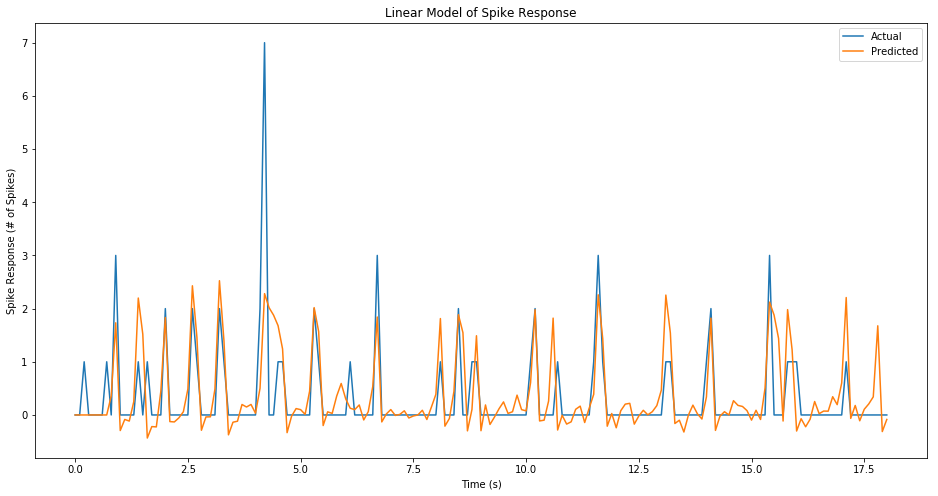

In [4]:
"""
    Fit Linear Model
"""
# Split into model and test data
R_model = np.mean(R[:,0:4], axis=1) # Do mean over the 4 trials
R_test = R[:,4]

# Calculate pseudo-inverse of S matrix
invS = np.linalg.pinv(S)

# Calculate W
W = np.matmul(invS,R_model)

# Plot actual and predicted response
time = [float(t)/10 for t in range(R_test.shape[0])]
plt.figure(figsize=(16,8))
plt.plot(time, R_test,label='Actual')
plt.plot(time, np.matmul(S,W),label='Predicted')
plt.title('Linear Model of Spike Response')
plt.xlabel('Time (s)')
plt.ylabel('Spike Response (# of Spikes)')
plt.legend()
plt.show()